In [18]:
import os, math
import numpy as np
import tensorflow.compat.v1 as tf
from glob       import glob
from PIL        import Image
from matplotlib import pyplot

tf.disable_v2_behavior()
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

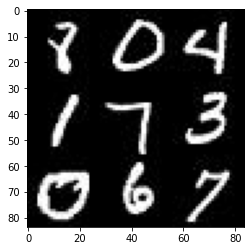

In [11]:
mnist_images = get_batch(glob('./mnist/*.jpg')[:10], 28, 28, 'L')
pyplot.imshow(images_square_grid(mnist_images, 'L'), cmap='gray')

In [12]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input    = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input       = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate


In [13]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        #First layer, output 14x14x64
        h1   = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        out1 = tf.maximum(h1, h1*alpha)

        #second layer, output 7x7x128
        h2   = tf.layers.conv2d(out1, 128, 5, strides=2, padding='same')
        bn2  = tf.layers.batch_normalization(h2)
        out2 = tf.maximum(bn2, bn2*alpha)

        #third layer, output 4x4x256
        h3   = tf.layers.conv2d(out2, 256, 5, strides=2, padding='same')
        bn3  = tf.layers.batch_normalization(h3)
        out3 = tf.maximum(bn3, bn3*alpha)

        #final dense layer
        dense_input = tf.reshape(out3, (-1, 4 * 4 * 256))
        logits      = tf.layers.dense(dense_input, 1)
        out         = tf.sigmoid(logits) 
        
    return out, logits

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        #input layer, fully connected
        h1 = tf.layers.dense(z, 7 * 7 * 256)
        
        #deconv layer 2, output 14x14x128
        h2   = tf.reshape(h1, (-1, 7, 7, 256))
        h2   = tf.layers.conv2d_transpose(h2, 128, 5, strides=2,padding='same')
        bn2  = tf.layers.batch_normalization(h2)
        out2 = tf.maximum(bn2, bn2*alpha)
        
        #deconv layer 3, output 28x28x3
        h3   = tf.layers.conv2d_transpose(out2, out_channel_dim, 5, strides=2,padding='same')
        bn3  = tf.layers.batch_normalization(h3)
        out3 = tf.maximum(bn3, bn3*alpha)
        
        #output
        output = tf.tanh(out3)
        
    
    return output

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    g_loss      = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    #included simply to pass test
    tf.trainable_variables()
    
    d_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')]
    g_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_train_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_train_vars)
    
    return d_opt, g_opt


In [56]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_channel =  1

    # Model Inputs
    real_input    = tf.placeholder(tf.float32, (None, data_shape[1], data_shape[2], image_channel))
    z_input       = tf.placeholder(tf.float32, (None, z_dim))
    lr            = tf.placeholder(tf.float32)

    # Generator
    g_model = generator(z_input, image_channel)
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(real_input)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Model Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    g_loss      = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    # Model Optimizer
    d_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')]
    g_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_train_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_train_vars)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('Starting epoch {} of {}'.format(epoch_i+1, epoch_count))
            for i, batch_images in enumerate(get_batches(batch_size)):
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr:learning_rate})
                
                if (i+1) % 10 == 0:

                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({z_input: batch_z, lr:learning_rate})
                    print('Batch {} of {}'.format(i+1, 60000//batch_size),
                          'Discriminator Loss: {:.4f}'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                if (i+1) % 100 == 0:
                    
                    # Show example generator output
                    cmap = None if image_mode == 'RGB' else 'gray'
                    z_dim = input_z.get_shape().as_list()[-1]
                    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

                    samples = sess.run(
                        generator(input_z, out_channel_dim, False),
                        feed_dict={input_z: example_z})

                    images_grid = images_square_grid(samples, image_mode)
                    pyplot.imshow(images_grid, cmap=cmap)
                    pyplot.show()
            

In [44]:
class Dataset(object):
    """
    Dataset
    """
    def __init__(self, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        self.image_mode = 'L'
        image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

In [ ]:
class MNIST_Generator():
    
    def __init__(self, data_files, z_dim, beta1, epoch_count, batch_size, lr):
    
        self.data_files = data_files
        self.data_shape = (len(data_files), 28, 28, 1)
        self.z_dim = z_dim
        self.beta1 = beta1
        self.epoch_count = epoch_count
        self.batch_size = batch_size
        self.lr = lr
        
        self.real_input, self.z_input, self.lr_tensor, \
        self.d_opt, self.g_opt, self.d_loss, self.g_loss = self.build_model()
        
    def build_model(self):
        
        real_input = tf.placeholder(tf.float32, (None, self.data_shape[1], self.data_shape[2], 1))
        z_input    = tf.placeholder(tf.float32, (None, self.z_dim))
        lr_tensor  = tf.placeholder(tf.float32)
        
        # Generator
        g_model = self.build_generator_model(z_input)
        
        # Discriminator
        d_model_real, d_logits_real = self.build_discriminator_model(real_input)
        d_model_fake, d_logits_fake = self.build_discriminator_model(g_model, reuse=True)
        
        # Model Loss
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
        d_loss      = d_loss_real + d_loss_fake
        
        g_loss      = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
        
        # Model Optimizer
        d_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')]
        g_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')]
        
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_opt = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(d_loss, var_list=d_train_vars)
            g_opt = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(g_loss, var_list=g_train_vars)
        
        return real_input, z_input, lr_tensor, d_opt, g_opt, d_loss, g_loss
        
    def build_generator_model(self, z_input, reuse=False, alpha=0.1):
        
        with tf.variable_scope('generator', reuse=reuse):
        
            #input layer, fully connected
            h1 = tf.layers.dense(z_input, 7 * 7 * 256)

            #deconv layer 2, output 14x14x128
            h2   = tf.reshape(h1, (-1, 7, 7, 256))
            h2   = tf.layers.conv2d_transpose(h2, 128, 5, strides=2,padding='same')
            bn2  = tf.layers.batch_normalization(h2)
            out2 = tf.maximum(bn2, bn2*alpha)

            #deconv layer 3, output 28x28x3
            h3   = tf.layers.conv2d_transpose(out2, 1, 5, strides=2,padding='same')
            bn3  = tf.layers.batch_normalization(h3)
            out3 = tf.maximum(bn3, bn3*alpha)

            #output
            output = tf.tanh(out3)
        
        return output
    
    def build_discriminator_model(self, images, reuse=False, alpha=0.1):
        
        with tf.variable_scope('discriminator', reuse=reuse):

            #First layer, output 14x14x64
            h1   = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            out1 = tf.maximum(h1, h1*alpha)

            #second layer, output 7x7x128
            h2   = tf.layers.conv2d(out1, 128, 5, strides=2, padding='same')
            bn2  = tf.layers.batch_normalization(h2)
            out2 = tf.maximum(bn2, bn2*alpha)

            #third layer, output 4x4x256
            h3   = tf.layers.conv2d(out2, 256, 5, strides=2, padding='same')
            bn3  = tf.layers.batch_normalization(h3)
            out3 = tf.maximum(bn3, bn3*alpha)

            #final dense layer
            dense_input = tf.reshape(out3, (-1, 4 * 4 * 256))
            logits      = tf.layers.dense(dense_input, 1)
            out         = tf.sigmoid(logits) 

        return out, logits
    
    def get_batches(self):

        current_index = 0
        while current_index + self.batch_size <= self.data_shape[0]:
            
            image_files   = self.data_files[current_index:current_index + self.batch_size]
            width, height = self.data_shape[1], self.data_shape[2]
            data_batch    = np.array([self.get_image(sample_file, width, height) for sample_file in image_files]).astype(np.float32)
            
            # Make sure the images are in 4 dimensions
            if len(data_batch.shape) < 4:
                data_batch = data_batch.reshape(data_batch.shape + (1,))

            current_index += self.batch_size
            yield data_batch / 255 - 0.5
        
    def get_image(self, image_path, width, height):
        
        image = Image.open(image_path)
        
        if image.size != (width, height):
            image = image.resize([width, height], Image.BILINEAR)

        return np.array(image.convert('L'))
    
    def images_square_grid(self, images):
        # Get maximum size for square grid of images
        save_size = math.floor(np.sqrt(images.shape[0]))
        
        # Scale to 0-255
        images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
        
        # Put images in a square arrangement
        images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3])
        )
        
        images_in_square = np.squeeze(images_in_square, 4)
        
        # Combine images to grid image
        new_im = Image.new('L', (images.shape[1] * save_size, images.shape[2] * save_size))
        
        for col_i, col_images in enumerate(images_in_square):
            for image_i, image in enumerate(col_images):
                im = Image.fromarray(image, 'L')
                new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

        return new_im

    def train(self):
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_i in range(self.epoch_count):
                print(f'Starting epoch {epoch_i+1} of {self.epoch_count}')
                
                for batch_i, batch_images in enumerate(self.get_batches()):
                    batch_images = batch_images * 2
                    batch_z      = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))
                    
                    sess.run(self.d_opt, feed_dict={
                        self.real_input : batch_images, 
                        self.z_input    : batch_z, 
                        self.lr_tensor  : self.lr
                    })
                    sess.run(self.g_opt, feed_dict={
                        self.real_input : batch_images, 
                        self.z_input    : batch_z, 
                        self.lr_tensor  : self.lr
                    })
                
                    if batch_i % 10 == 0:

                        train_loss_d = self.d_loss.eval({self.z_input: batch_z, self.real_input: batch_images, self.lr_tensor:self.lr})
                        train_loss_g = self.g_loss.eval({self.z_input: batch_z, self.lr_tensor:self.lr})
                        
                        print(f'Batch {batch_i} of {60000//self.batch_size}',
                              f'Discriminator Loss: {train_loss_d:.4f}',
                              f'Generator Loss: {train_loss_g:.4f}')

                    if batch_i % 100 == 0:
                        self.show_sample_generated(sess, 1)
    
    def show_sample_generated(self, sess, n_images):

        input_z   = tf.random_uniform((1, self.z_dim),-1,1)
        z_dim     = input_z.get_shape().as_list()[-1]
        example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

        samples = sess.run(
            self.build_generator_model(input_z, reuse=True),
            feed_dict={input_z: example_z}
        )
        
        images_grid = self.images_square_grid(samples)
        pyplot.imshow(images_grid, cmap='gray')
        pyplot.show()


(60000, 28, 28, 1)
Starting epoch 1 of 2
Batch 0 of 1875 Discriminator Loss: 0.9052 Generator Loss: 0.6754


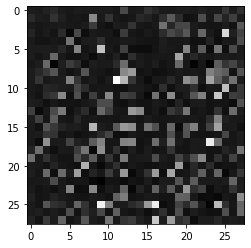

Batch 10 of 1875 Discriminator Loss: 0.0095 Generator Loss: 6.3147
Batch 20 of 1875 Discriminator Loss: 0.3225 Generator Loss: 1.9847
Batch 30 of 1875 Discriminator Loss: 0.5108 Generator Loss: 1.4567
Batch 40 of 1875 Discriminator Loss: 0.3767 Generator Loss: 2.8675
Batch 50 of 1875 Discriminator Loss: 0.3199 Generator Loss: 2.7632
Batch 60 of 1875 Discriminator Loss: 0.3935 Generator Loss: 1.6447
Batch 70 of 1875 Discriminator Loss: 1.9188 Generator Loss: 0.3182
Batch 80 of 1875 Discriminator Loss: 0.8250 Generator Loss: 2.9986
Batch 90 of 1875 Discriminator Loss: 0.7878 Generator Loss: 1.0654
Batch 100 of 1875 Discriminator Loss: 0.5419 Generator Loss: 1.8769


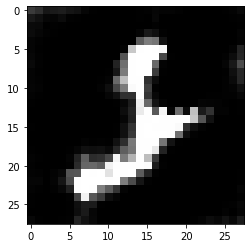

Batch 110 of 1875 Discriminator Loss: 0.8031 Generator Loss: 0.9945
Batch 120 of 1875 Discriminator Loss: 0.5266 Generator Loss: 2.2191
Batch 130 of 1875 Discriminator Loss: 0.5703 Generator Loss: 2.5400
Batch 140 of 1875 Discriminator Loss: 0.7375 Generator Loss: 1.0562
Batch 150 of 1875 Discriminator Loss: 0.6761 Generator Loss: 1.2008
Batch 160 of 1875 Discriminator Loss: 0.6418 Generator Loss: 2.3402
Batch 170 of 1875 Discriminator Loss: 0.5540 Generator Loss: 1.8883
Batch 180 of 1875 Discriminator Loss: 0.3076 Generator Loss: 2.2214
Batch 190 of 1875 Discriminator Loss: 0.6883 Generator Loss: 1.3135
Batch 200 of 1875 Discriminator Loss: 1.0762 Generator Loss: 1.1091


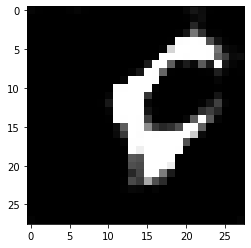

Batch 210 of 1875 Discriminator Loss: 0.6539 Generator Loss: 1.6238
Batch 220 of 1875 Discriminator Loss: 0.7039 Generator Loss: 1.2591
Batch 230 of 1875 Discriminator Loss: 0.4584 Generator Loss: 2.9384
Batch 240 of 1875 Discriminator Loss: 0.5170 Generator Loss: 1.7078
Batch 250 of 1875 Discriminator Loss: 0.4246 Generator Loss: 2.4382
Batch 260 of 1875 Discriminator Loss: 0.5497 Generator Loss: 1.2793
Batch 270 of 1875 Discriminator Loss: 0.6021 Generator Loss: 2.2304
Batch 280 of 1875 Discriminator Loss: 0.8869 Generator Loss: 0.8162
Batch 290 of 1875 Discriminator Loss: 0.6500 Generator Loss: 1.2417
Batch 300 of 1875 Discriminator Loss: 0.4691 Generator Loss: 1.6746


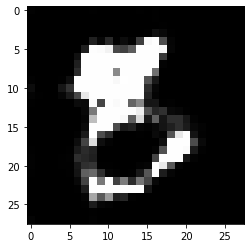

Batch 310 of 1875 Discriminator Loss: 0.6579 Generator Loss: 1.5894
Batch 320 of 1875 Discriminator Loss: 0.8427 Generator Loss: 1.0669
Batch 330 of 1875 Discriminator Loss: 0.8905 Generator Loss: 2.9095
Batch 340 of 1875 Discriminator Loss: 0.3987 Generator Loss: 1.9561
Batch 350 of 1875 Discriminator Loss: 0.5768 Generator Loss: 1.6986
Batch 360 of 1875 Discriminator Loss: 0.6414 Generator Loss: 1.5805
Batch 370 of 1875 Discriminator Loss: 0.4709 Generator Loss: 2.2280
Batch 380 of 1875 Discriminator Loss: 0.4133 Generator Loss: 2.0856
Batch 390 of 1875 Discriminator Loss: 0.6588 Generator Loss: 2.1354
Batch 400 of 1875 Discriminator Loss: 0.6749 Generator Loss: 1.3424


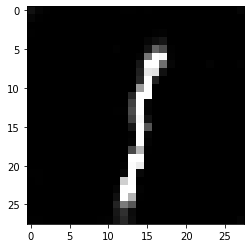

Batch 410 of 1875 Discriminator Loss: 0.4304 Generator Loss: 2.2550
Batch 420 of 1875 Discriminator Loss: 0.7642 Generator Loss: 2.2538
Batch 430 of 1875 Discriminator Loss: 0.6506 Generator Loss: 1.2558
Batch 440 of 1875 Discriminator Loss: 0.7744 Generator Loss: 1.3354
Batch 450 of 1875 Discriminator Loss: 0.4876 Generator Loss: 1.8876
Batch 460 of 1875 Discriminator Loss: 0.8907 Generator Loss: 1.2053
Batch 470 of 1875 Discriminator Loss: 0.4594 Generator Loss: 1.6932
Batch 480 of 1875 Discriminator Loss: 0.7461 Generator Loss: 1.1127
Batch 490 of 1875 Discriminator Loss: 0.5503 Generator Loss: 1.6049
Batch 500 of 1875 Discriminator Loss: 0.6338 Generator Loss: 2.2390


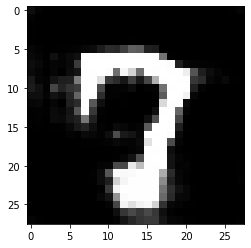

Batch 510 of 1875 Discriminator Loss: 0.4671 Generator Loss: 1.8882
Batch 520 of 1875 Discriminator Loss: 0.6975 Generator Loss: 1.5060
Batch 530 of 1875 Discriminator Loss: 0.4568 Generator Loss: 2.1832
Batch 540 of 1875 Discriminator Loss: 0.4819 Generator Loss: 2.0686
Batch 550 of 1875 Discriminator Loss: 1.3152 Generator Loss: 3.0363
Batch 560 of 1875 Discriminator Loss: 0.5303 Generator Loss: 1.8904
Batch 570 of 1875 Discriminator Loss: 0.7694 Generator Loss: 1.0392
Batch 580 of 1875 Discriminator Loss: 0.8489 Generator Loss: 2.3672
Batch 590 of 1875 Discriminator Loss: 0.9664 Generator Loss: 0.7006
Batch 600 of 1875 Discriminator Loss: 0.4595 Generator Loss: 1.7611


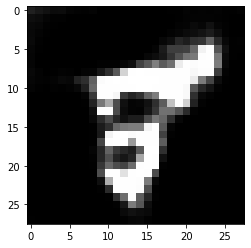

Batch 610 of 1875 Discriminator Loss: 0.5241 Generator Loss: 1.5986
Batch 620 of 1875 Discriminator Loss: 0.7057 Generator Loss: 1.2852
Batch 630 of 1875 Discriminator Loss: 0.5547 Generator Loss: 1.8870
Batch 640 of 1875 Discriminator Loss: 0.5670 Generator Loss: 2.4520
Batch 650 of 1875 Discriminator Loss: 0.4269 Generator Loss: 1.6768
Batch 660 of 1875 Discriminator Loss: 0.6489 Generator Loss: 2.8496
Batch 670 of 1875 Discriminator Loss: 0.5390 Generator Loss: 1.9658
Batch 680 of 1875 Discriminator Loss: 0.9696 Generator Loss: 0.7396
Batch 690 of 1875 Discriminator Loss: 0.5103 Generator Loss: 1.8570
Batch 700 of 1875 Discriminator Loss: 0.6023 Generator Loss: 1.2495


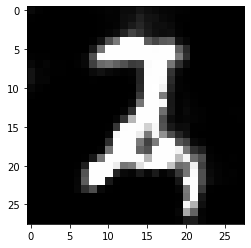

Batch 710 of 1875 Discriminator Loss: 1.1111 Generator Loss: 0.7669
Batch 720 of 1875 Discriminator Loss: 0.5823 Generator Loss: 1.8501
Batch 730 of 1875 Discriminator Loss: 0.8878 Generator Loss: 3.4757
Batch 740 of 1875 Discriminator Loss: 0.5505 Generator Loss: 2.3938
Batch 750 of 1875 Discriminator Loss: 0.7720 Generator Loss: 1.4435
Batch 760 of 1875 Discriminator Loss: 0.9033 Generator Loss: 1.1264
Batch 770 of 1875 Discriminator Loss: 0.5124 Generator Loss: 1.9513
Batch 780 of 1875 Discriminator Loss: 0.8718 Generator Loss: 2.5070
Batch 790 of 1875 Discriminator Loss: 0.6495 Generator Loss: 1.2200
Batch 800 of 1875 Discriminator Loss: 0.5091 Generator Loss: 3.4566


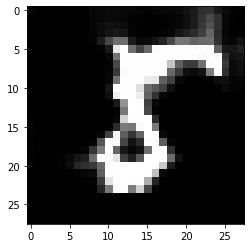

Batch 810 of 1875 Discriminator Loss: 0.5406 Generator Loss: 1.3950
Batch 820 of 1875 Discriminator Loss: 0.5547 Generator Loss: 1.3489
Batch 830 of 1875 Discriminator Loss: 0.4277 Generator Loss: 2.0606
Batch 840 of 1875 Discriminator Loss: 0.6149 Generator Loss: 1.6364
Batch 850 of 1875 Discriminator Loss: 0.5552 Generator Loss: 1.5798
Batch 860 of 1875 Discriminator Loss: 0.6187 Generator Loss: 3.4657
Batch 870 of 1875 Discriminator Loss: 0.5314 Generator Loss: 1.5396
Batch 880 of 1875 Discriminator Loss: 1.2872 Generator Loss: 0.7611
Batch 890 of 1875 Discriminator Loss: 0.4990 Generator Loss: 1.8813
Batch 900 of 1875 Discriminator Loss: 0.7398 Generator Loss: 1.5467


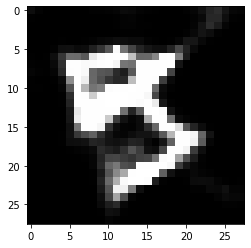

Batch 910 of 1875 Discriminator Loss: 0.5489 Generator Loss: 1.5464
Batch 920 of 1875 Discriminator Loss: 0.4739 Generator Loss: 1.7898
Batch 930 of 1875 Discriminator Loss: 0.5122 Generator Loss: 2.1682
Batch 940 of 1875 Discriminator Loss: 0.5900 Generator Loss: 2.9115
Batch 950 of 1875 Discriminator Loss: 0.4165 Generator Loss: 2.4627
Batch 960 of 1875 Discriminator Loss: 0.4373 Generator Loss: 2.4070
Batch 970 of 1875 Discriminator Loss: 0.5350 Generator Loss: 2.1454
Batch 980 of 1875 Discriminator Loss: 0.5932 Generator Loss: 1.8882
Batch 990 of 1875 Discriminator Loss: 0.5169 Generator Loss: 2.8340
Batch 1000 of 1875 Discriminator Loss: 0.5366 Generator Loss: 2.1680


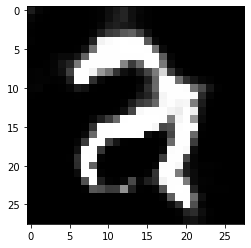

Batch 1010 of 1875 Discriminator Loss: 0.8041 Generator Loss: 0.9495
Batch 1020 of 1875 Discriminator Loss: 0.4575 Generator Loss: 2.3105
Batch 1030 of 1875 Discriminator Loss: 0.8063 Generator Loss: 0.9650
Batch 1040 of 1875 Discriminator Loss: 0.4674 Generator Loss: 1.7280
Batch 1050 of 1875 Discriminator Loss: 0.4926 Generator Loss: 2.0186
Batch 1060 of 1875 Discriminator Loss: 0.4121 Generator Loss: 2.8551
Batch 1070 of 1875 Discriminator Loss: 0.3534 Generator Loss: 2.0920
Batch 1080 of 1875 Discriminator Loss: 0.6046 Generator Loss: 1.4605
Batch 1090 of 1875 Discriminator Loss: 0.4546 Generator Loss: 1.5513
Batch 1100 of 1875 Discriminator Loss: 0.3685 Generator Loss: 2.7748


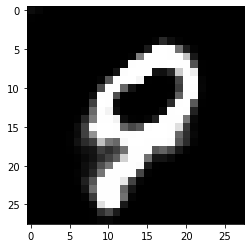

Batch 1110 of 1875 Discriminator Loss: 0.4084 Generator Loss: 2.1690
Batch 1120 of 1875 Discriminator Loss: 0.4342 Generator Loss: 2.0093
Batch 1130 of 1875 Discriminator Loss: 0.5719 Generator Loss: 1.4045
Batch 1140 of 1875 Discriminator Loss: 0.4330 Generator Loss: 2.1968
Batch 1150 of 1875 Discriminator Loss: 0.3214 Generator Loss: 1.9977
Batch 1160 of 1875 Discriminator Loss: 0.3267 Generator Loss: 1.8975
Batch 1170 of 1875 Discriminator Loss: 0.4867 Generator Loss: 1.6826
Batch 1180 of 1875 Discriminator Loss: 0.4371 Generator Loss: 3.4128
Batch 1190 of 1875 Discriminator Loss: 0.4936 Generator Loss: 1.5520
Batch 1200 of 1875 Discriminator Loss: 0.4412 Generator Loss: 3.1661


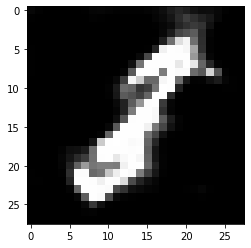

Batch 1210 of 1875 Discriminator Loss: 0.5796 Generator Loss: 1.5026
Batch 1220 of 1875 Discriminator Loss: 1.0430 Generator Loss: 0.8245
Batch 1230 of 1875 Discriminator Loss: 0.4276 Generator Loss: 2.5938
Batch 1240 of 1875 Discriminator Loss: 0.4152 Generator Loss: 1.9681
Batch 1250 of 1875 Discriminator Loss: 0.2883 Generator Loss: 2.9809
Batch 1260 of 1875 Discriminator Loss: 0.4055 Generator Loss: 2.3918
Batch 1270 of 1875 Discriminator Loss: 0.7774 Generator Loss: 0.9378
Batch 1280 of 1875 Discriminator Loss: 0.4457 Generator Loss: 2.9827
Batch 1290 of 1875 Discriminator Loss: 0.5820 Generator Loss: 2.6712
Batch 1300 of 1875 Discriminator Loss: 0.3979 Generator Loss: 2.3213


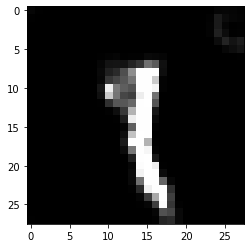

Batch 1310 of 1875 Discriminator Loss: 0.3238 Generator Loss: 2.3688
Batch 1320 of 1875 Discriminator Loss: 0.4602 Generator Loss: 1.8507
Batch 1330 of 1875 Discriminator Loss: 0.4586 Generator Loss: 2.9134
Batch 1340 of 1875 Discriminator Loss: 0.4773 Generator Loss: 1.5136
Batch 1350 of 1875 Discriminator Loss: 0.2577 Generator Loss: 3.5229
Batch 1360 of 1875 Discriminator Loss: 0.2513 Generator Loss: 3.1119
Batch 1370 of 1875 Discriminator Loss: 0.3376 Generator Loss: 3.3212


In [ ]:
epochs = 2
batch_size = 32
z_dim = 150
learning_rate = .001
beta1 = .5

mnist_dataset = glob('./mnist/*.jpg')
with tf.Graph().as_default():
    mnist_generator = MNIST_Generator(mnist_dataset, z_dim, beta1, epochs, batch_size, learning_rate)
    print(mnist_generator.data_shape)
    
    mnist_generator.train()